In [ ]:
#| default_exp datasets.classical_exp

# Libraries

In [1]:
#| export
import numpy as np

import torch
import math

import jax
import jax.numpy as jnp
from jax import random
jax.config.update('jax_platform_name', 'cpu')

from fastai.vision.all import DataLoaders
from torch.utils.data import TensorDataset, DataLoader as DataLoader_torch

In [2]:
#| hide
import matplotlib.pyplot as plt

In [29]:
from nbdev import nbdev_export
nbdev_export() 

# Generating functions

In [4]:
#| export

def create_traj_hammer(mass, times):
  """Creates the traj of the hammer action, moves along e_k = 0.5*(e_x+e_y) directions """

  def get_position(mass,time):
    k = 2/(1+3*mass)*time
    xy = jnp.array([k/jnp.sqrt(2), k/jnp.sqrt(2)])
    return xy

  return jax.vmap(get_position, in_axes=(None,0))(mass,times)


def create_traj_electric(mass, charge, times):
  """Creates the traj of the electric action, moves along e_k = 0.5*(e_x+e_y) directions """

  def get_position(mass,charge,time):
    k = charge/(4*mass)*time**2
    xy = jnp.array([k/jnp.sqrt(2), k/jnp.sqrt(2)])
    return xy

  return jax.vmap(get_position, in_axes=(None,None,0))(mass,charge,times)

def create_traj_electric_only_test(mass,charge, times):
  """Creates the traj of the electric action, moves along e_k = 0.5*(e_x+e_y) directions """

  def get_position(mass,charge,time):
    k = charge/(4)*time**2
    xy = jnp.array([k/jnp.sqrt(2), k/jnp.sqrt(2)])
    return xy

  return jax.vmap(get_position, in_axes=(None,None,0))(mass,charge,times)


def create_traj_magnetic(mass, charge, times):
  """Creates the traj of the magnetic effect"""

  def get_position(mass,charge,time):
    theta_0 = 3*jnp.pi/4
    R = 2*mass/(charge*(1+3*mass))
    x = R*jnp.cos(-charge/mass*time+theta_0)+R/jnp.sqrt(2)
    y = R*jnp.sin(-charge/mass*time+theta_0)-R/jnp.sqrt(2)
    xy = jnp.array([x, y])
    return xy


  return jax.vmap(get_position, in_axes=(None,None,0))(mass,charge,times)



def create_traj(key, times, alpha_1, alpha_2, alpha_ext, num_samples,
                min_mass = 0.4, 
                max_mass = 1.75,
                min_charge = -1.,
                max_charge = -0.5, 
                return_separate=False):
    """Creates the trajectory of the particles given the alphas, created st size(traj)=R_max~1, traj=[[x1,y1],[x2,y2],...]"""

    masses = jax.random.uniform(key, shape=(num_samples,), minval = min_mass, maxval = max_mass)
    key, subkey = random.split(key)
    charges = jax.random.uniform(subkey, shape=(num_samples,), minval = min_charge, maxval = max_charge)
    
    traj_H = jax.vmap(create_traj_hammer, in_axes=(0,None))(masses, times)
    traj_E = jax.vmap(create_traj_electric, in_axes=(0,0,None))(masses, charges, times)
    traj_M = jax.vmap(create_traj_magnetic, in_axes=(0,0,None))(masses, charges, times)
    
    if return_separate:
        return alpha_1*traj_H + alpha_ext*traj_M, alpha_2*traj_E + alpha_ext*traj_M
    else:
        return alpha_1*traj_H + alpha_2*traj_E + alpha_ext*traj_M


In [5]:
#| export
def create_traj_mass(key, times, masses):
  """Creates the trajectory of the particles given the alphas, created st size(traj)=R_max~1, traj=[[x1,y1],[x2,y2],...]"""

  traj_H = jax.vmap(create_traj_hammer, in_axes=(0,None))(masses, times)  

  return traj_H 


def create_traj_charge(key, times, masses, charges):
  """Creates the trajectory of the particles given the alphas, created st size(traj)=R_max~1, traj=[[x1,y1],[x2,y2],...]"""

  traj_E = jax.vmap(create_traj_electric, in_axes=(0,0,None))(masses, charges, times)  

  return traj_E 

### Tests

In [7]:
key = jax.random.PRNGKey(1)
times = np.arange(0.,2,0.1)

num_samples = 3000

min_mass = 0.75-0.55*0.65
max_mass = 0.75+(1+0.55)*0.65

min_charge = -(1.25-0.95*1.5)
max_charge = -(1.25+(1+0.95)*1.5)

#### Hammer action

In [8]:
alpha_1 = 1.0
alpha_2 = 0
alpha_ext = 0.


trajs_hammer = create_traj(key, times, alpha_1, alpha_2, alpha_ext, num_samples)

Text(0, 0.5, 'X component')

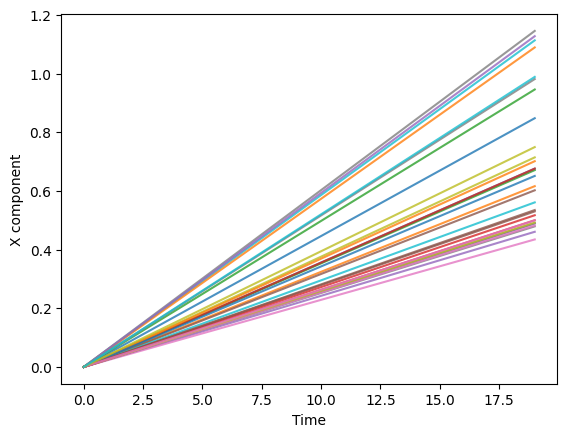

In [10]:
for traj in trajs_hammer[:30]:
    plt.plot(traj[:, 0], alpha=0.8)
plt.xlabel('Time')
plt.ylabel('X component')


Text(0.5, 0, 'Mass')

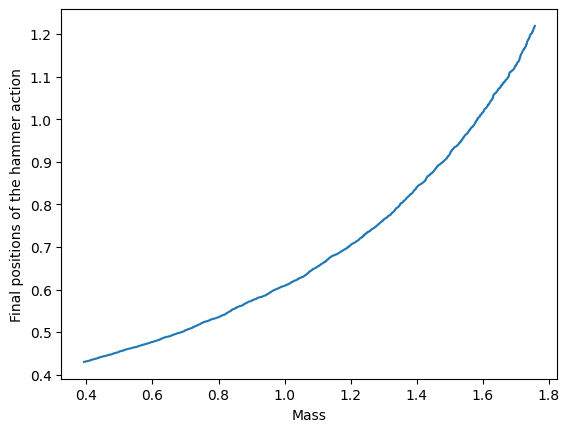

In [11]:
plt.plot(np.linspace(min_mass, max_mass, num_samples), trajs_hammer[:,-1,0].sort())
plt.ylabel('Final positions of the hammer action')
plt.xlabel('Mass')

#### Electric action

In [12]:
alpha_1 = 0
alpha_2 = 1.
alpha_ext = 0.


trajs_e = create_traj(key, times, alpha_1, alpha_2, alpha_ext, num_samples)

Text(0, 0.5, 'X component')

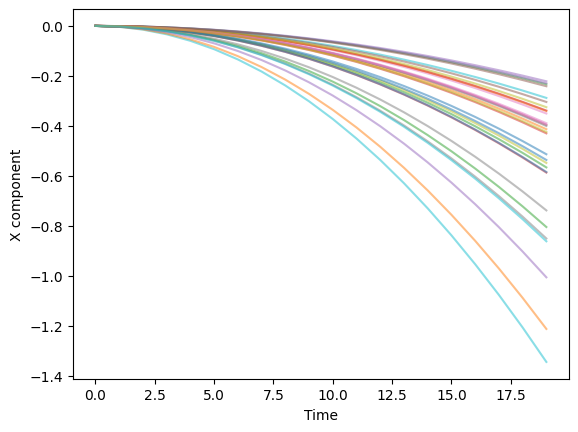

In [13]:
for traj in trajs_e[:30]:
    plt.plot(traj[:, 1], alpha=0.5)
plt.xlabel('Time')
plt.ylabel('X component')


Text(0.5, 0, 'Charge')

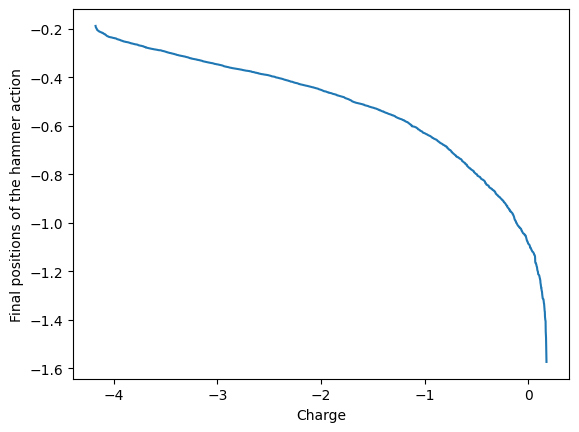

In [14]:
plt.plot(np.linspace(min_charge, max_charge, num_samples), trajs_e[:,-1,0].sort())
plt.ylabel('Final positions of the hammer action')
plt.xlabel('Charge')

#### Comparing Mass, Electric and Magnetic trajectories

In [15]:
min_mass = 0.4
max_mass = 1.75

min_charge = -1.7
max_charge = -0.5

masses = jax.random.uniform(key, shape=(num_samples,), minval = min_mass, maxval = max_mass)
key, subkey = random.split(key)
charges = jax.random.uniform(subkey, shape=(num_samples,), minval = min_charge, maxval = max_charge)


times = np.linspace(0,2,200)   

traj_H = jax.vmap(create_traj_hammer, in_axes=(0,None))(masses, times)
traj_E = jax.vmap(create_traj_electric, in_axes=(0,0,None))(masses, charges, times)
traj_M = jax.vmap(create_traj_magnetic, in_axes=(0,0,None))(masses, charges, times)

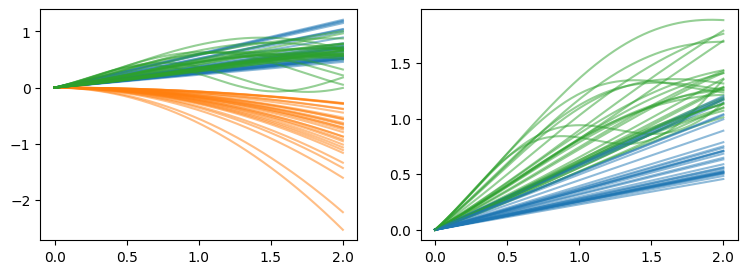

In [17]:
fig, ax = plt.subplots(1,2, figsize = (9,3))

for traj in traj_H[:30]:
    ax[0].plot(times, traj[:, 1], alpha=0.5, c = 'C0')

for traj in traj_E[:30]:
    ax[0].plot(times, traj[:, 1], alpha=0.5, c = 'C1')

for traj in traj_M[:30]:
    ax[0].plot(times, traj[:, 1], alpha=0.5, c = 'C2')


for trajh, trajm in zip(traj_H[:30], traj_M[:30]):
    ax[1].plot(times, trajh[:, 1], alpha=0.5, c = 'C0')
    ax[1].plot(times, trajh[:, 1] + trajm[:, 1], alpha=0.5, c = 'C2')

(array([2.94338003, 1.73149466, 0.83806806, 0.88923058, 0.75761677,
        0.3224809 , 0.14487146, 0.06364794, 0.02584533, 0.00606876]),
 array([0.        , 0.12948832, 0.25897664, 0.38846493, 0.51795328,
        0.64744157, 0.77692986, 0.9064182 , 1.03590655, 1.16539478,
        1.29488313]),
 <BarContainer object of 10 artists>)

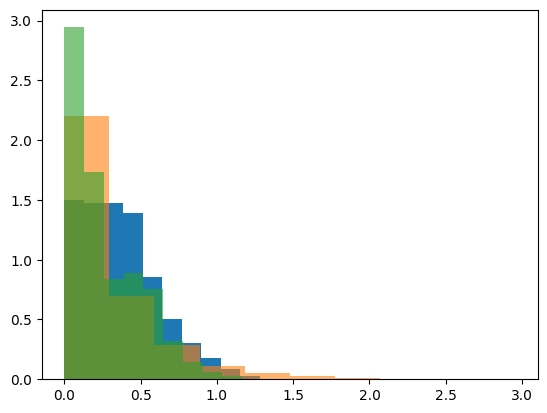

In [19]:
plt.hist(traj_H.flatten(), density = 1)
plt.hist(np.abs(traj_E.flatten()), alpha = 0.6, density = 1)
plt.hist(np.abs(traj_M.flatten()), alpha = 0.6, density = 1)

# Single trajectory input dataset

In [20]:
#| export
def hammer_electric_dataset(dataset_size=500,
                            size_train = 0.8,
                            BS = 100,
                            key_jax = None,
                            times = np.arange(0.,2,0.1),
                            act_rep_val = 1,
                            device = 'cuda' if torch.cuda.is_available() else 'cpu',
                            dims_concat = False):    

    if key_jax is None:
        key = jax.random.PRNGKey(1)
    else:
        key = jax.random.PRNGKey(key_jax)
        
    # Hammer action
    trajs_h = create_traj(key,
                        times, 
                            alpha_1 = 1., 
                            alpha_2 = 0, 
                            alpha_ext = 0, 
                            num_samples = math.ceil(dataset_size/2))
    if dims_concat:
        trajs_h = trajs_h.transpose(0,2,1).reshape(int(math.ceil(dataset_size/2)), jnp.size(times)*2)            
    else:
        trajs_h = trajs_h.reshape(int(math.ceil(dataset_size/2)), jnp.size(times)*2)    

    # Electric action
    trajs_e = create_traj(key,
                          times,
                            alpha_1 = 0, 
                            alpha_2 = 1., 
                            alpha_ext = 0, 
                            num_samples = math.ceil(dataset_size/2))
    if dims_concat:
        trajs_e = trajs_e.transpose(0,2,1).reshape(int(math.ceil(dataset_size/2)), jnp.size(times)*2)
    else:
        trajs_e = trajs_e.reshape(int(math.ceil(dataset_size/2)), jnp.size(times)*2)
        
    # Action representation
    a_hammer_rep =  jnp.array([[0, act_rep_val]]*math.ceil(dataset_size/2))   
    a_elec_rep =  jnp.array([[act_rep_val, 0]]*math.ceil(dataset_size/2))

    # Merging dataset
    train_set = (jnp.concatenate([trajs_h, trajs_e], axis=0),
                 jnp.concatenate([a_hammer_rep, a_elec_rep], axis=0))
    train_set = jax.device_put(train_set)


    # Shuffle the tensor
    inputs = torch.hstack((torch.tensor(np.array(train_set[0]), dtype=torch.float32),
                           torch.tensor(np.array(train_set[1]), dtype=torch.float32)))
    indices = torch.randperm(inputs.size(0))
    inputs = inputs[indices]

    # Create dataset as inputs (all data) and outputs (only trajectory, no action))
    dataset = TensorDataset(inputs[:int(size_train*dataset_size)].to(device),
                            inputs[:,:-2][:int(size_train*dataset_size)].to(device))    

    # Same for test set
    dataset_test = TensorDataset(inputs[int(size_train*dataset_size):].to(device),
                                inputs[:,:-2][int(size_train*dataset_size):].to(device))  

    # Now define the dataloaders
    loader = DataLoader_torch(dataset, batch_size = BS, shuffle = True)
    loader_test = DataLoader_torch(dataset_test, batch_size = BS, shuffle = True)


    return DataLoaders(loader, loader_test), loader_test, loader

## Tests

In [21]:
data, loader_test, loader = hammer_electric_dataset(BS = 100, dataset_size=2000, times = np.linspace(0.,20,20))

In [22]:
data = np.concatenate([b[0].cpu().detach() for b in loader_test])

In [23]:
action = data[:,-1]
last_val = data[:,19]

(array([47., 29., 21., 27., 12., 14., 16.,  8., 14.,  8.]),
 array([2.14553213, 2.51686406, 2.88819599, 3.25952816, 3.63086009,
        4.00219202, 4.37352419, 4.74485588, 5.11618805, 5.48751974,
        5.85885191]),
 <BarContainer object of 10 artists>)

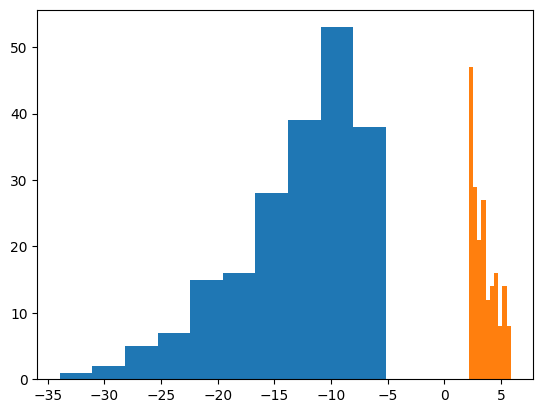

In [24]:
plt.hist(last_val[action == 0])
plt.hist(last_val[action != 0])

Text(0, 0.5, 'X component')

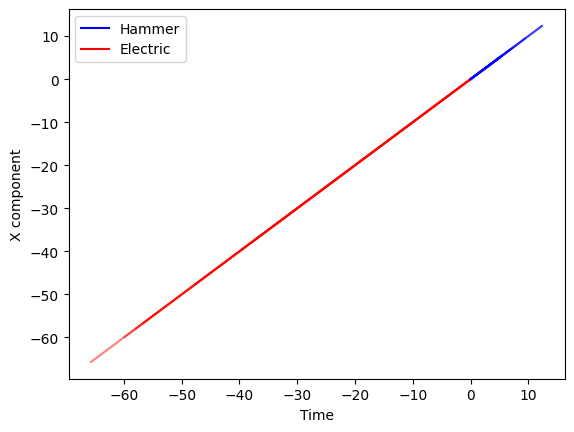

In [25]:
for traj in data[:20]:
    
    action = traj[-2]
    traj = traj[:-2].reshape(20,2)
    
    plt.plot(traj[:, 0], traj[:, 1], c = 'b' if action == 0 else 'r', alpha = 0.5)

plt.plot([], [], c='b', label='Hammer')
plt.plot([], [], c='r', label='Electric')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X component')

# Both trajectories input dataset

In [27]:
#| export
def hammer_electric_dataset_double_traj(dataset_size=500,
                                        size_train = 0.8,
                                        BS = 100,
                                        key_jax = None,
                                        times = np.arange(0.,2,0.1),
                                        act_rep_val = 1, 
                                        alpha_1 = 1.,
                                        alpha_2 = 1.,
                                        alpha_ext = 0.,
                                        device = 'cuda' if torch.cuda.is_available() else 'cpu', 
                                        min_mass = 0.4, 
                                        max_mass = 1.75,
                                        min_charge = -1.,
                                        max_charge = -0.5,
                                        dims_concat = False
                                        ): 


    assert int(dataset_size/2) == dataset_size/2

    dataset_size = int(dataset_size/2)

    if key_jax is None:
        key = jax.random.PRNGKey(1)
    else:
        key = jax.random.PRNGKey(key_jax)

        
    # Get trajs for both actions (remember to keep alphas at 1)
    trajs_h, trajs_e = create_traj(key,
                                    times, 
                                    alpha_1 = alpha_1, 
                                    alpha_2 = alpha_2, 
                                    alpha_ext = alpha_ext, 
                                    num_samples = dataset_size,
                                    min_mass = min_mass,
                                    max_mass = max_mass,
                                    min_charge = min_charge,
                                    max_charge = max_charge,
                                    return_separate = True)

    if dims_concat:
        trajs_h = trajs_h.transpose(0,2,1).reshape(dataset_size, jnp.size(times)*2)   
        trajs_e = trajs_e.transpose(0,2,1).reshape(dataset_size, jnp.size(times)*2)         
    else:
        trajs_h = trajs_h.reshape(dataset_size, jnp.size(times)*2)  
        trajs_e = trajs_e.reshape(dataset_size, jnp.size(times)*2) 

    input_trajs = np.concatenate([trajs_h, trajs_e], axis=1)
    inputs = np.vstack([input_trajs, input_trajs]) 

    a_hammer_rep =  np.array([[0, act_rep_val]]*dataset_size)
    a_elec_rep =  np.array([[act_rep_val, 0]]*dataset_size)

    inputs = np.hstack((inputs, np.concatenate([a_hammer_rep, a_elec_rep], axis=0)))

    outputs = np.vstack([trajs_h, trajs_e])

    # Shuffle the tensor
    indices = torch.randperm(inputs.shape[0])
    inputs = torch.tensor(inputs[indices], dtype=torch.float32)
    outputs = torch.tensor(outputs[indices], dtype=torch.float32)

    dataset = TensorDataset(inputs[:int(size_train*dataset_size)].to(device),
                            outputs[:int(size_train*dataset_size)].to(device))  

    dataset_test = TensorDataset(inputs[int(size_train*dataset_size):].to(device),
                                outputs[int(size_train*dataset_size):].to(device))  

    loader = DataLoader_torch(dataset, batch_size = BS, shuffle = True)
    loader_test = DataLoader_torch(dataset_test, batch_size = BS, shuffle = True)

    return DataLoaders(loader, loader_test), loader_test, loader

## Tests

In [28]:
data, loader_test, loader = hammer_electric_dataset_double_traj(BS = 100, dataset_size=2000, times = np.linspace(0.,20,20))